# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [1]:
%load_ext autoreload
%autoreload 2

import shutil

from benchmarks.rm_dynamics import RailwayMarketDynamics

from pathlib import Path

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

Number of services to generate:  20


Number of service requests generated: 20


,Number of Services
OUIGO,3
AVLO,8
AVE,4
IRYO,4


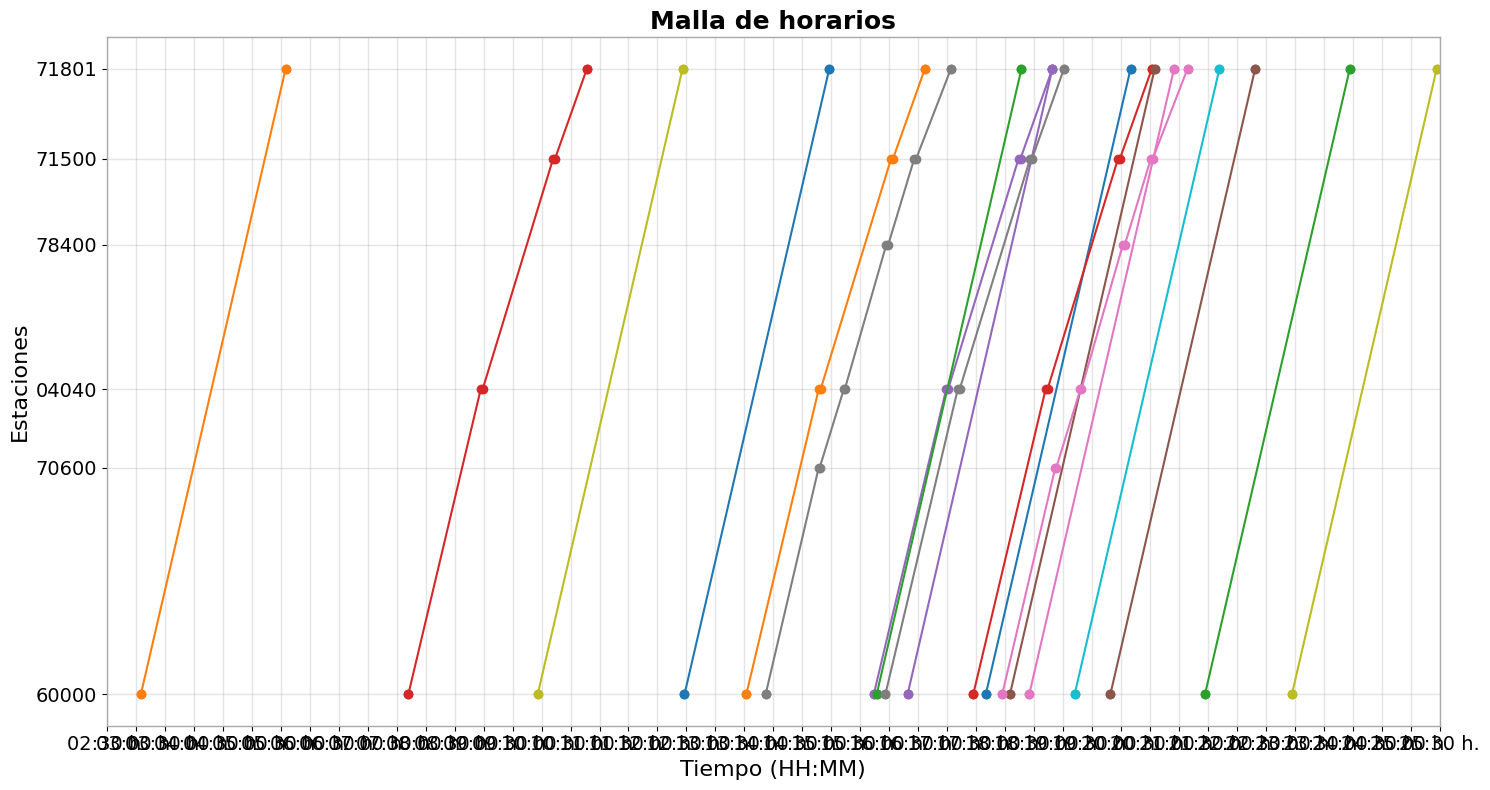

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


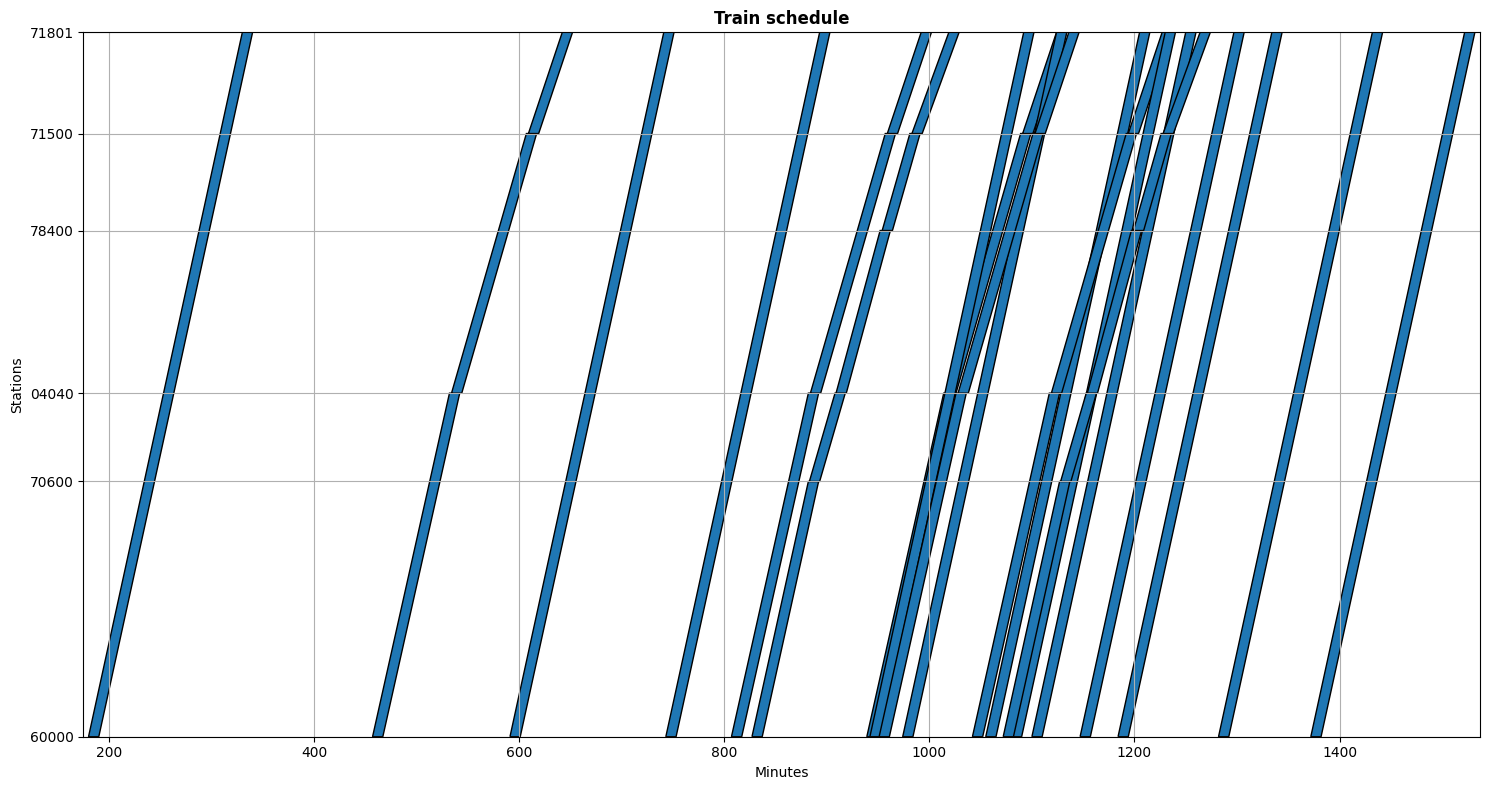

  0%|          | 0/11 [00:00<?, ?it/s]

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),OUIGO,AVLO,IRYO,AVE
1,2,2521.093055,3.396082,12,11.0,44.0,66.67 %,62.5 %,50.0 %,75.0 %
2,3,2503.179647,3.415025,12,8.0,53.0,66.67 %,62.5 %,50.0 %,75.0 %
7,8,2489.592032,3.401957,12,16.0,50.0,66.67 %,62.5 %,50.0 %,75.0 %
10,11,2487.068771,3.387000,12,13.0,53.0,66.67 %,62.5 %,50.0 %,75.0 %
0,1,2486.570572,3.410234,12,15.0,53.0,66.67 %,62.5 %,50.0 %,75.0 %
4,5,2483.248926,3.401548,12,14.0,53.0,66.67 %,62.5 %,50.0 %,75.0 %
8,9,2479.302758,3.401389,12,14.0,60.0,66.67 %,62.5 %,50.0 %,75.0 %
3,4,2475.994929,3.389549,12,13.0,61.0,66.67 %,62.5 %,50.0 %,75.0 %
6,7,2472.515411,3.400545,12,13.0,53.0,66.67 %,62.5 %,50.0 %,75.0 %
5,6,2471.667623,3.386713,12,16.0,63.0,66.67 %,62.5 %,50.0 %,75.0 %


Global GSA status:
	Total execution time: 37.3827 s.
	Execution Time (by run) - Mean: 3.3984 s. - Std: 0.0091 s.
	Revenue - Mean: 2484.6669 - Std: 16.3742
	Scheduled Trains - Mean: 12.0 - Std: 0.0
	Median solution: Run 5
	Max Revenue: 3888.5 - WARNING!: Scheduling all services could not be feasible


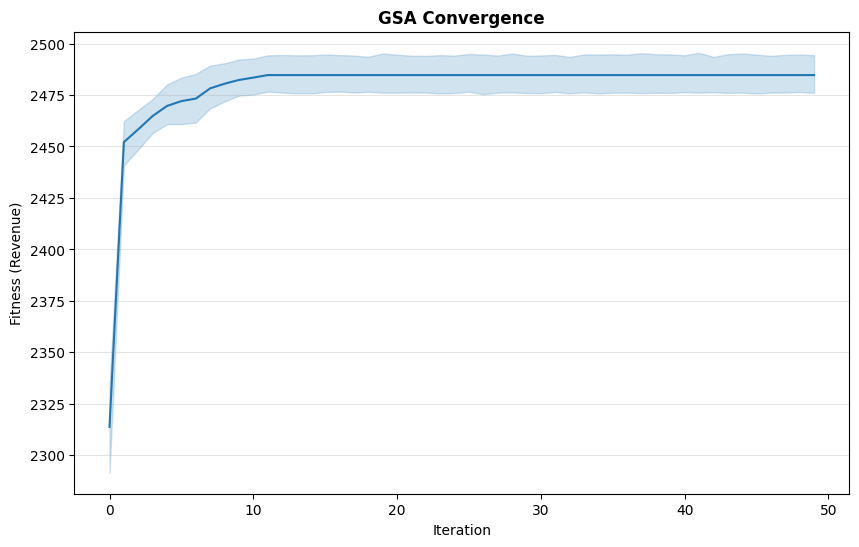

{'03612_2024-06-25-21.27': {'60000': [1290.0, 1290.0], '71801': [1440.0, 1440.0]}, '02731_2024-06-25-17.27': {'60000': [1049.0, 1049.0], '04040': [1124.0, 1127.0], '71500': [1200.0, 1203.0], '71801': [1236.0, 1236.0]}, '04161_2024-06-25-13.52': {'60000': [831.0, 831.0], '70600': [886.0, 889.0], '04040': [914.0, 918.0], '78400': [961.0, 965.0], '71500': [992.0, 995.0], '71801': [1031.0, 1031.0]}, '03612_2024-06-25-22.57': {'60000': [1376.0, 1376.0], '71801': [1526.0, 1526.0]}, '03612_2024-06-25-19.12': {'60000': [1151.0, 1151.0], '71801': [1301.0, 1301.0]}, '03612_2024-06-25-12.28': {'60000': [744.0, 744.0], '71801': [894.0, 894.0]}, '03612_2024-06-25-3.05': {'60000': [185.0, 185.0], '71801': [335.0, 335.0]}, '02731_2024-06-25-7.42': {'60000': [462.0, 462.0], '04040': [537.0, 541.0], '71500': [614.0, 617.0], '71801': [650.0, 650.0]}, '03612_2024-06-25-19.49': {'60000': [1190.0, 1190.0], '71801': [1340.0, 1340.0]}, '04161_2024-06-25-17.57': {'60000': [1077.0, 1077.0], '70600': [1132.0, 1

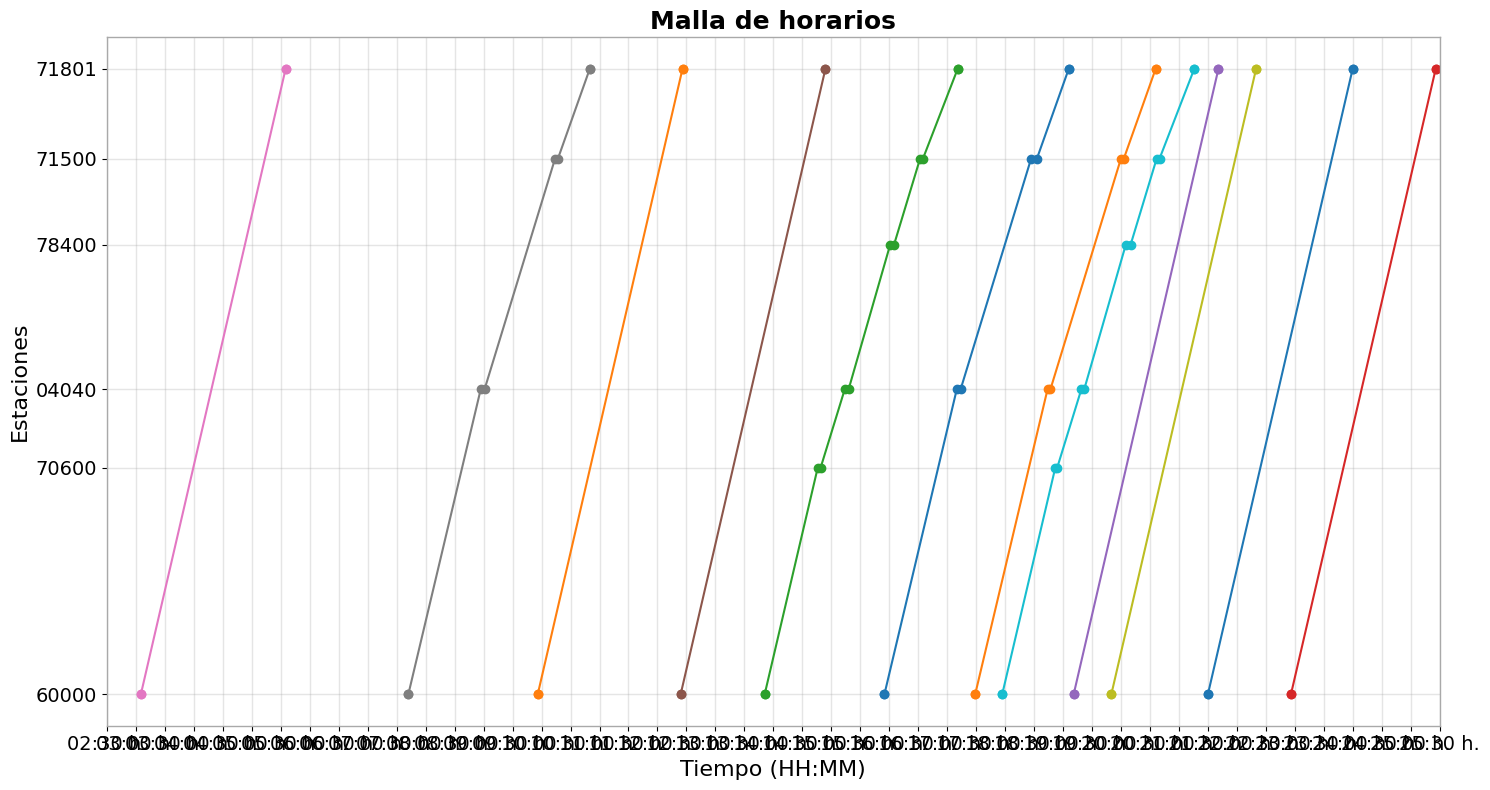

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


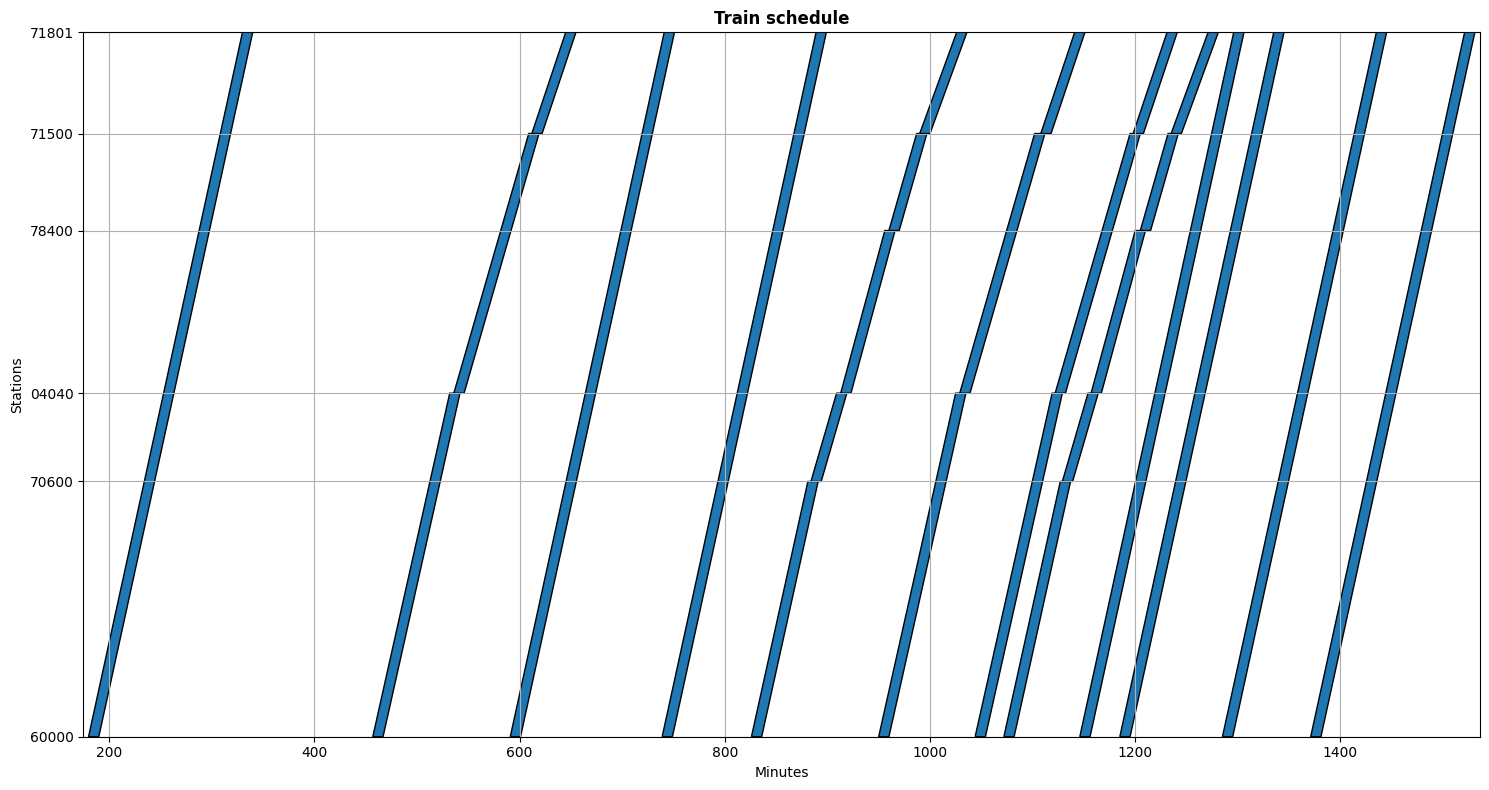

Data from demand plot: 
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 5681
	Status: User bought a service which was not the one with the best utility. - Passengers: 2803
	Status: User bought the ticket with best utility. - Passengers: 955
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  3758
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 657 - Percentage: 17.48 %
		Seat: Turista - Passengers: 2455 - Percentage: 65.33 %
		Seat: TuristaPlus - Passengers: 646 - Percentage: 17.19 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  3758
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Premium - Number of tickets sold: 15
			Seat: Turista - Number of tickets sold: 81
			Seat: TuristaPlus - Number of tickets sold: 78
		Date: 2023-06-12
			Seat: Premium - Number of tickets sold: 9
			Seat: Turista - Number of tick

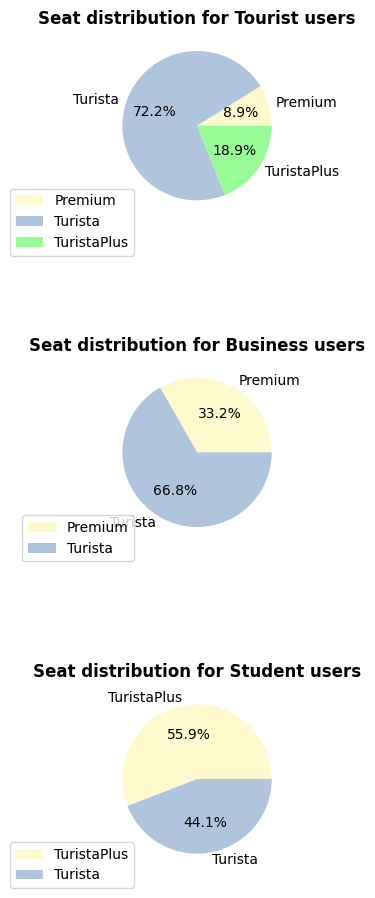

In [3]:
rmd = RailwayMarketDynamics(supply_config_path=supply_config_path,
                            demand_config_path=demand_config_path,
                            generator_config_path=generator_config_path,
                            generator_save_path=generator_save_path,
                            seed = 21)

services = rmd.run(gsa_supply_save_path=supply_save_path,
                    robin_save_path=Path(f'{robin_save_path}output.csv'),
                    gsa_population=20,
                    gsa_iters=50,
                    gsa_runs=11,
                    gsa_chaotic=False,
                    gsa_verbosity=False)

In [15]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!
